In [1]:
import pandas as pd 
import os 
import numpy as np 
import scipy.signal as sig
from raw_pose_analysis_funs.gait_metric_support import (support_interp, support_filter_lowpass,id_toe_off_heel_strike)

In [2]:
# test double support 

# load yolo data 
yolo_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_hc_outputs\DS_HC\2024-05-02\001_merge_mp_yolo_dfs\gait_vertical_left_DS_HC_2024-05-02_yolo.csv'
yolo_df = pd.read_csv(yolo_path)

# ground truth file name 
current_filename = 'DS_HC_gait_vertical_left'
video_id_date_name = current_filename

# fpts
fps = 30 

In [3]:
dir_out_prefix = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_double_support_code'
max_gap = 0.12 # max gap to interpolate over 
cutoff = 0.4
order = 1


In [4]:
# ground truth anotation of turn start and stop time 
# watch videos frame by frame: e on keyboard = move forward one frame 
ground_truth_support_path = r'C:\Users\mmccu\Box\Brainwalk\Home Video Walking\Megan Project\bw_data_and_code\gait\gait_hc_videos\visual_annotation_ground_truth\vertical_double_support_frames.xlsx'
ground_truth_support_df = pd.read_excel(ground_truth_support_path, sheet_name = 'Sheet1', engine='openpyxl')
ground_truth_support_df

,filename,subjectID,task,walk_direction_num,fps,r_heel_strike_frames,QA_seconds,frames between r heel strike and l toe off,l_toe_off_frames,frames between l toe off and l heel strike,l_heel_strike_frames,frames between l heel strike and r toe off,r_toe_off_frames,frames between r toe off and r heel strike
0,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,away_1,60,60,1.000000,13.0,73.0,22.0,95.0,9.0,104.0,24.0
1,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,away_1,60,128,2.133333,10.0,138.0,22.0,160.0,10.0,170.0,23.0
2,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,away_1,60,193,3.216667,9.0,202.0,23.0,225.0,7.0,232.0,24.0
3,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,away_1,60,256,4.266667,8.0,264.0,22.0,286.0,11.0,297.0,23.0
4,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,toward_1,60,394,6.566667,9.0,403.0,28.0,431.0,7.0,438.0,25.0
5,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,toward_1,60,463,7.716667,9.0,472.0,23.0,495.0,9.0,504.0,25.0
6,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,toward_1,60,529,8.816667,10.0,539.0,24.0,563.0,10.0,573.0,24.0
7,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,toward_1,60,597,9.950000,8.0,605.0,26.0,631.0,12.0,643.0,NaN
8,DS_HC_gait_vertical_right,DS_HC,gait_vertical_right,away_1,60,54,0.900000,10.0,64.0,29.0,93.0,10.0,103.0,25.0
9,DS_HC_gait_vertical_right,DS_HC,gait_vertical_right,away_1,60,128,2.133333,8.0,136.0,25.0,161.0,10.0,171.0,24.0


In [5]:
# select ground truth data 
ground_truth_support_current = ground_truth_support_df.loc[ground_truth_support_df['filename'] == current_filename]

r_heel_strike_frames = ground_truth_support_current['r_heel_strike_frames']
l_toe_off_frames = ground_truth_support_current['l_toe_off_frames'] 
l_heel_strike_frames = ground_truth_support_current['l_heel_strike_frames'] 
r_toe_off_frames = ground_truth_support_current['r_toe_off_frames'] 


In [6]:
import scipy.signal as sig 

# interpolate 
yolo_support_interp_dfs = support_interp(yolo_df, video_id_date_name, dir_out_prefix, max_gap, fps)
right_ankle_y = yolo_support_interp_dfs[0]
left_ankle_y = yolo_support_interp_dfs[1]

In [7]:
def ankle_y_vel_accel_peak_min(ank_y_df, diff_period, peaks_distance, peaks_prominence_percent_max):
    ank_y_df['diff1_vel'] = ank_y_df.iloc[: ,2].diff(periods = diff_period) # interpolated data 
    ank_y_df['diff2_accel'] = ank_y_df['diff1_vel'].diff(periods = diff_period)

    # find local min and max of velocity and acceleration  
    peak_vel_prominence = peaks_prominence_percent_max * ank_y_df['diff1_vel'].max(skipna = True)
    peak_accel_prominence = peaks_prominence_percent_max * ank_y_df['diff1_vel'].max(skipna = True)
    
    vel_peak_i, _ = sig.find_peaks(ank_y_df['diff1_vel'], 
                                   distance = peaks_distance, 
                                   prominence = peak_vel_prominence)
    vel_valley_i, _ = sig.find_peaks(-ank_y_df['diff1_vel'], 
                                     distance = peaks_distance, 
                                     prominence = peak_vel_prominence)
    accel_peak_i, _ = sig.find_peaks(ank_y_df['diff2_accel'],
                                     distance = peaks_distance,  
                                     prominence = peak_accel_prominence)
    accel_valley_i, _ = sig.find_peaks(-ank_y_df['diff2_accel'], 
                                       distance = peaks_distance, 
                                       prominence = peak_accel_prominence)

    # find_peaks uses positional indices, not value of index column. Account for gaps in frame with nan values
    vel_peak_df = ank_y_df.iloc[vel_peak_i, :]
    vel_valley_df = ank_y_df.iloc[vel_valley_i, :]
    accel_peak_df = ank_y_df.iloc[accel_peak_i, :]
    accel_valley_df = ank_y_df.iloc[accel_valley_i, :]

    return([ank_y_df, vel_peak_df, vel_valley_df, accel_peak_df, accel_valley_df])

In [8]:
# save lists 
    # 0 = data for each frame 
    # 1 = vel peak data frame 
    # 2 = vel valley data frame 
    # 3 = accel peak data frame 
    # 4 = accel valley data frame 

diff_period = round(.167 * fps)
peaks_distance = round(.167 * fps)
peaks_prominence_percent_max = .10 # percent of maximum value that peak must be greater than to be considered peak or value 


right_ank_y_data = ankle_y_vel_accel_peak_min(right_ankle_y, diff_period, peaks_distance, peaks_prominence_percent_max)
left_ank_y_data = ankle_y_vel_accel_peak_min(left_ankle_y, diff_period, peaks_distance, peaks_prominence_percent_max)

In [9]:
# plots # set y max for vertical lines 
x_max = max([r_heel_strike_frames.max(), 
             l_toe_off_frames.max(), 
             l_heel_strike_frames.max(), 
             r_toe_off_frames.max()])

r_y_max = right_ank_y_data[0]['right_ankle_Y_yolo_negative_interpolated'].max(skipna = True)
r_y_min = right_ank_y_data[0]['right_ankle_Y_yolo_negative_interpolated'].min(skipna = True)

r_grad_max = right_ank_y_data[0]['diff1_vel'].max(skipna = True)
r_grad_min = right_ank_y_data[0]['diff1_vel'].min(skipna = True)

r_grad2_max = right_ank_y_data[0]['diff2_accel'].max(skipna = True)
r_grad2_min = right_ank_y_data[0]['diff2_accel'].min(skipna = True)

l_y_max = left_ank_y_data[0]['left_ankle_Y_yolo_negative_interpolated'].max(skipna = True)
l_y_min = left_ank_y_data[0]['left_ankle_Y_yolo_negative_interpolated'].min(skipna = True)

l_grad_max = left_ank_y_data[0]['diff1_vel'].max(skipna = True)
l_grad_min = left_ank_y_data[0]['diff1_vel'].min(skipna = True)

l_grad2_max = left_ank_y_data[0]['diff2_accel'].max(skipna = True)
l_grad2_min = left_ank_y_data[0]['diff2_accel'].min(skipna = True)


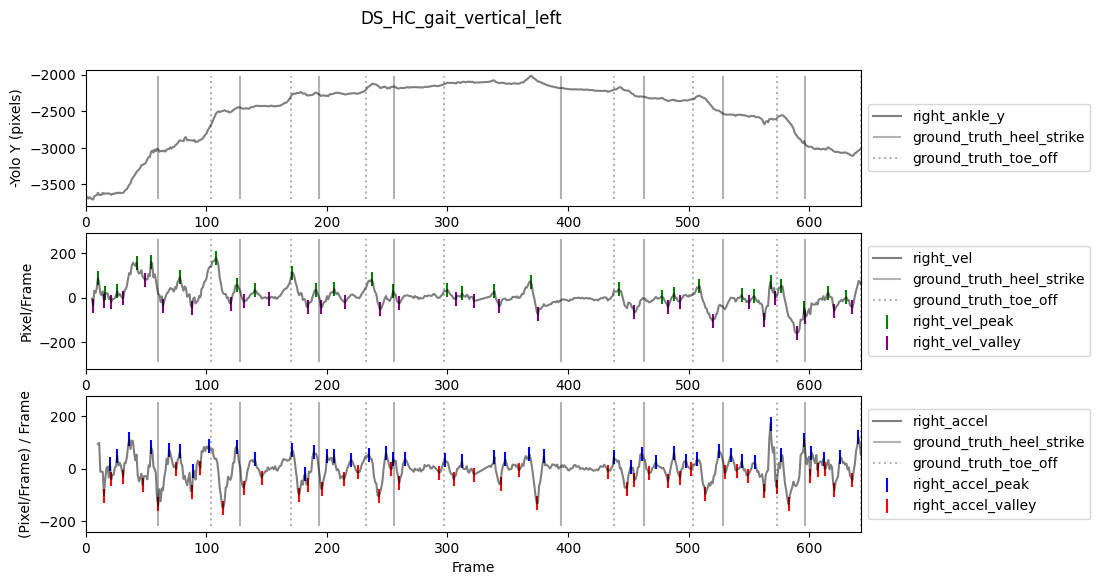

In [10]:
# plots 
import matplotlib.pyplot as plt 

# right 
fig1, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 6))
fig1.suptitle(video_id_date_name)
ax1.plot(right_ank_y_data[0]['right_ankle_Y_yolo_negative_interpolated'], color = 'black', alpha = 0.5, label = 'right_ankle_y')
ax1.vlines(x = r_heel_strike_frames, ymax = r_y_max, ymin = r_y_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'ground_truth_heel_strike')
ax1.vlines(x = r_toe_off_frames, ymax = r_y_max, ymin = r_y_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'ground_truth_toe_off')
ax1.set_ylabel('-Yolo Y (pixels)')
ax1.set_xlabel('Frame')
ax1.set_xlim(0, x_max)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Diff 1 - velocity 
ax2.plot(right_ank_y_data[0]['diff1_vel'], color = 'black', alpha = 0.5, label = 'right_vel')
ax2.vlines(x = r_heel_strike_frames, ymax = r_grad_max, ymin = r_grad_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'ground_truth_heel_strike')
ax2.vlines(x = r_toe_off_frames, ymax = r_grad_max, ymin = r_grad_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'ground_truth_toe_off')
ax2.scatter(right_ank_y_data[1]['frame'], 
            right_ank_y_data[1]['diff1_vel'], 
            color = 'green',  
            marker = "|", 
            s = 100,
            label = 'right_vel_peak')
ax2.scatter(right_ank_y_data[2]['frame'], 
            right_ank_y_data[2]['diff1_vel'], 
            color = 'purple', 
            marker = "|",
            s = 100,
            label = 'right_vel_valley')
ax2.set_ylabel('Pixel/Frame')
ax2.set_xlabel('Frame')
ax2.set_xlim(0, x_max)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# gradient 2 
ax3.plot(right_ank_y_data[0]['diff2_accel'], color = 'black', alpha = 0.5, label = 'right_accel')
ax3.vlines(x = r_heel_strike_frames, ymax = r_grad2_max, ymin = r_grad2_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'ground_truth_heel_strike')
ax3.vlines(x = r_toe_off_frames, ymax = r_grad2_max, ymin = r_grad2_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'ground_truth_toe_off')
ax3.scatter(right_ank_y_data[3]['frame'], 
            right_ank_y_data[3]['diff2_accel'], 
            color = 'blue',  
            marker = "|", 
            s = 100,
            label = 'right_accel_peak')
ax3.scatter(right_ank_y_data[4]['frame'], 
            right_ank_y_data[4]['diff2_accel'], 
            color = 'red', 
            marker = "|",
            s = 100,
            label = 'right_accel_valley')
ax3.set_ylabel('(Pixel/Frame) / Frame')
ax3.set_xlabel('Frame')
ax3.set_xlim(0, x_max)
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# save plots 
output_plot_1 = os.path.normpath(os.path.join(dir_out_prefix, (video_id_date_name + '_right_support.png')))
fig1.savefig(output_plot_1, bbox_inches = 'tight')

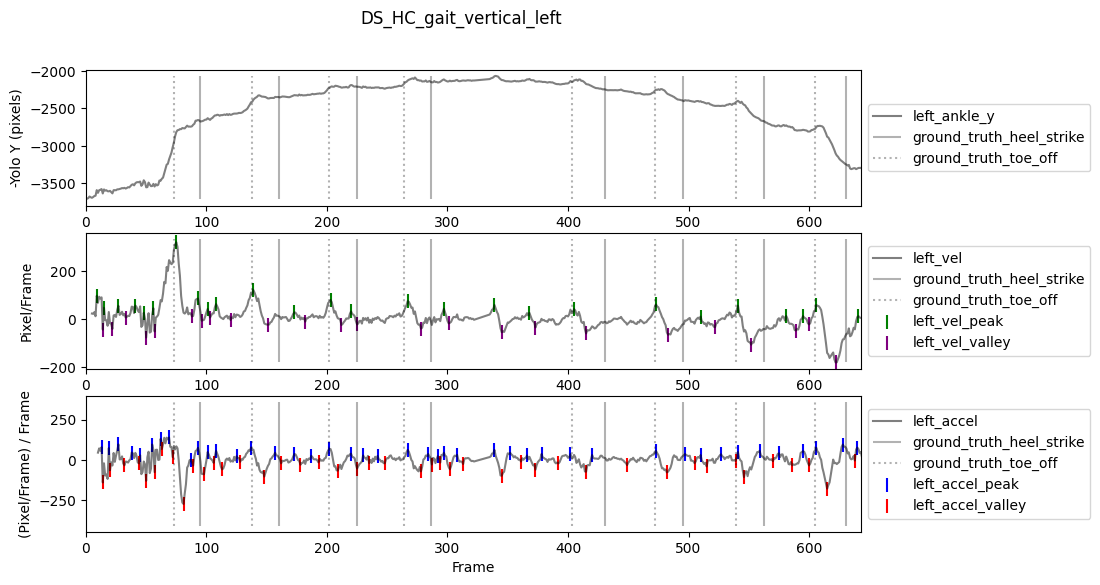

In [11]:
# fig 2 = left 
fig2, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 6))
fig2.suptitle(video_id_date_name)
ax1.plot(left_ank_y_data[0]['left_ankle_Y_yolo_negative_interpolated'], color = 'black', alpha = 0.5, label = 'left_ankle_y')
ax1.vlines(x = l_heel_strike_frames, ymax = l_y_max, ymin = l_y_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'ground_truth_heel_strike')
ax1.vlines(x = l_toe_off_frames, ymax = l_y_max, ymin = l_y_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'ground_truth_toe_off')
ax1.set_ylabel('-Yolo Y (pixels)')
ax1.set_xlabel('Frame')
ax1.set_xlim(0, x_max)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# gradient 1 
ax2.plot(left_ank_y_data[0]['diff1_vel'], color = 'black', alpha = 0.5, label = 'left_vel')
ax2.vlines(x = l_heel_strike_frames, ymax = l_grad_max, ymin = l_grad_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'ground_truth_heel_strike')
ax2.vlines(x = l_toe_off_frames, ymax = l_grad_max, ymin = l_grad_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'ground_truth_toe_off')
ax2.scatter(left_ank_y_data[1]['frame'], 
            left_ank_y_data[1]['diff1_vel'], 
            color = 'green', 
            marker = "|",
            s = 100,
            label = 'left_vel_peak')
ax2.scatter(left_ank_y_data[2]['frame'], 
            left_ank_y_data[2]['diff1_vel'], 
            color = 'purple',
            marker = "|",
            s = 100,
            label = 'left_vel_valley')
ax2.set_ylabel('Pixel/Frame')
ax2.set_xlabel('Frame')
ax2.set_xlim(0, x_max)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# gradient 2
ax3.plot(left_ank_y_data[0]['diff2_accel'], color = 'black', alpha = 0.5, label = 'left_accel')
ax3.vlines(x = l_heel_strike_frames, ymax = l_grad2_max, ymin = l_grad2_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'ground_truth_heel_strike')
ax3.vlines(x = l_toe_off_frames, ymax = l_grad2_max, ymin = l_grad2_min, 
           color = 'black',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'ground_truth_toe_off')
ax3.scatter(left_ank_y_data[3]['frame'], 
            left_ank_y_data[3]['diff2_accel'], 
            color = 'blue',  
            marker = "|", 
            s = 100,
            label = 'left_accel_peak')
ax3.scatter(left_ank_y_data[4]['frame'], 
            left_ank_y_data[4]['diff2_accel'], 
            color = 'red', 
            marker = "|",
            s = 100,
            label = 'left_accel_valley')
ax3.set_ylabel('(Pixel/Frame) / Frame')
ax3.set_xlabel('Frame')
ax3.set_xlim(0, x_max)
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))


output_plot_2 = os.path.normpath(os.path.join(dir_out_prefix, (video_id_date_name + '_left_support.png')))
fig2.savefig(output_plot_2, bbox_inches = 'tight')

In [12]:
# right
positive_r_ankle_grad = right_ankle_y_gradient_filt.loc[right_ankle_y_gradient_filt > 0]
positive_r_ankle_grad_frames = positive_r_ankle_grad.index

r_peak_df = pd.DataFrame(index = range(len(right_peak_frames_2)), columns = ['count', 'frame', 'gait_event'])
for right_peak_i, current_right_peak in enumerate(right_peak_frames_2):
    r_peak_df.loc[right_peak_i, 'count'] = right_peak_i
    r_peak_df.loc[right_peak_i, 'frame'] = current_right_peak 

    if current_right_peak in positive_r_ankle_grad_frames: 
        r_peak_df.loc[right_peak_i, 'gait_event'] = 'right_toe_off'
    # if vel at that frame is negative, peak = heel strike
    else: 
        r_peak_df.loc[right_peak_i, 'gait_event'] = 'right_heel_strike'

r_valley_df = pd.DataFrame(index = range(len(right_valley_frames_2)), columns = ['count', 'frame', 'gait_event'])
for right_valley_i, current_right_valley in enumerate(right_valley_frames_2):
    r_valley_df.loc[right_valley_i, 'count'] = right_valley_i
    r_valley_df.loc[right_valley_i, 'frame'] = current_right_valley
    
    # if vel at that frame is positive, valley = heel strike
    if current_right_valley in positive_r_ankle_grad_frames: 
        r_valley_df.loc[right_valley_i, 'gait_event'] = 'right_heel_strike'
    # if vel at that frame is negative, valley = toe off 
    else: 
        r_valley_df.loc[right_valley_i, 'gait_event'] = 'right_toe_off'

# left
positive_l_ankle_grad = left_ankle_y_gradient_filt.loc[left_ankle_y_gradient_filt > 0]
positive_l_ankle_grad_frames = positive_l_ankle_grad.index

l_peak_df = pd.DataFrame(index = range(len(left_peak_frames_2)), columns = ['count', 'frame', 'gait_event'])
for left_peak_i, current_left_peak in enumerate(left_peak_frames_2):
    l_peak_df.loc[left_peak_i, 'count'] = left_peak_i
    l_peak_df.loc[left_peak_i, 'frame'] = current_left_peak
    # if vel at that frame is positive, peak = toe off
    if current_left_peak in positive_l_ankle_grad_frames: 
        l_peak_df.loc[left_peak_i, 'gait_event'] = 'left_toe_off'
    # if vel at that frame is negative, peak = heel strike
    else: 
        l_peak_df.loc[left_peak_i, 'gait_event'] = 'left_heel_strike'

l_valley_df = pd.DataFrame(index = range(len(left_valley_frames_2)), columns = ['count', 'frame', 'gait_event'])
for left_valley_i, current_left_valley in enumerate(left_valley_frames_2):
    l_valley_df.loc[left_valley_i, 'count'] = left_valley_i
    l_valley_df.loc[left_valley_i, 'frame'] = current_left_valley
    
    # if vel at that frame is positive, valley = heel strike
    if current_left_valley in positive_l_ankle_grad_frames: 
        l_valley_df.loc[left_valley_i, 'gait_event'] = 'left_heel_strike'
    # if vel at that frame is negative, valley = toe off 
    else: 
        l_valley_df.loc[left_valley_i, 'gait_event'] = 'left_toe_off'

NameError: name 'right_ankle_y_gradient_filt' is not defined

In [ ]:
all_df = pd.concat([r_peak_df, r_valley_df, l_peak_df, l_valley_df])
all_df = all_df.reset_index(drop=True)

all_df_pivoted = all_df.pivot_table(index='count', columns='gait_event', values='frame', aggfunc='first')

# if first event is right_toe off, order columns as 
if all_df_pivoted.loc[0,'right_toe_off'] < all_df_pivoted.loc[0,'left_toe_off']:
    col_order = ['right_toe_off', 'right_heel_strike', 'left_toe_off', 'left_heel_strike']
else: 
    col_order = ['left_toe_off', 'left_heel_strike' 'right_toe_off', 'right_heel_strike']

all_events = all_df_pivoted[col_order]

In [ ]:
#get first steps 
all_events_start = all_events.iloc[1:4, :]
print(all_events_start.head())

first_frame = all_events_start.iloc[0,0]
last_frame = all_events_start.iloc[2,3]
print(first_frame)
print(last_frame)

# y position 
r_ank_y_start = right_ankle_y.loc[first_frame:last_frame, 'right_ankle_Y_yolo_negative_interpolated']
l_ank_y_start = left_ankle_y.loc[first_frame:last_frame, 'left_ankle_Y_yolo_negative_interpolated']

# gradient 2 (acceleration)
right_ankle_y_gradient_2_start = right_ankle_y_gradient_2[first_frame:last_frame]
left_ankle_y_gradient_2_start = left_ankle_y_gradient_2[first_frame:last_frame]

# ground truth frames 
r_heel_strike_frames_start = r_heel_strike_frames[(r_heel_strike_frames > first_frame) & (r_heel_strike_frames < last_frame)]
r_toe_off_frames_start = r_toe_off_frames[(r_toe_off_frames > first_frame) & (r_toe_off_frames < last_frame)]
l_heel_strike_frames_start = l_heel_strike_frames[(l_heel_strike_frames > first_frame) & (l_heel_strike_frames < last_frame)]
l_toe_off_frames_start = l_toe_off_frames[(l_toe_off_frames > first_frame) & (l_toe_off_frames < last_frame)]

In [ ]:
# plot calculated and true toe off and heel strike 
fig3, ax1 = plt.subplots(figsize=(10, 6))
fig3.suptitle(video_id_date_name)
ax1.plot(right_ankle_y_gradient_2_start, color = 'orange', alpha = 0.5, label = 'right_ankle_grad2')
ax1.plot(left_ankle_y_gradient_2_start, color = 'black', alpha = 0.5, label = 'left_ankle_grad2')

ax1.vlines(x = r_heel_strike_frames_start, ymax = l_grad2_max, ymin = l_grad2_min, 
           color = 'blue',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'r_ground_truth_heel_strike')
ax1.vlines(x = all_events_start['right_heel_strike'], ymax = l_grad2_max, ymin = l_grad2_min, 
           color = 'blue',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'r_calc_heel_strike')


ax1.vlines(x = r_toe_off_frames_start, ymax = l_grad2_max, ymin = l_grad2_min, 
           color = 'red',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'r_ground_truth_toe_off')
ax1.vlines(x = all_events_start['right_toe_off'], ymax = l_grad2_max, ymin = l_grad2_min, 
           color = 'red',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'r_calc_toe_off')


ax1.vlines(x = l_heel_strike_frames_start, ymax = l_grad2_max, ymin = l_grad2_min, 
           color = 'green',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'l_ground_truth_heel_strike')
ax1.vlines(x = all_events_start['left_heel_strike'], ymax = l_grad2_max, ymin = l_grad2_min, 
           color = 'green',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'l_calc_heel_strike')


ax1.vlines(x = l_toe_off_frames_start, ymax = l_grad2_max, ymin = l_grad2_min, 
           color = 'purple',
           alpha = 0.3, 
           linestyle = 'solid', 
           label = 'l_ground_truth_toe_off')
ax1.vlines(x = all_events_start['left_toe_off'], ymax = l_grad2_max, ymin = l_grad2_min, 
           color = 'purple',
           alpha = 0.3, 
           linestyle = 'dotted', 
           label = 'l_calc_toe_off')

ax1.set_ylabel('-Yolo Y (pixels)')
ax1.set_xlabel('Frame')
ax1.set_xlim(0, x_max)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

output_plot_3 = os.path.normpath(os.path.join(dir_out_prefix, (video_id_date_name + '_calc_vs_ground_truth_gait_events.png')))
fig3.savefig(output_plot_3, bbox_inches = 'tight')